## First, I'll load the required data and setup keras settings

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import numpy as np
# use non standard flow_from_directory
from utils.image_preprocessing_ver2 import ImageDataGenerator
# it outputs y_batch that contains embeddings

from utils.mobilenet import get_mobilenet
import keras
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras import optimizers
from keras import regularizers
from keras import backend as K
from keras.layers import Lambda, concatenate, Activation
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import matplotlib.pyplot as plt
from keras.layers import Activation, GlobalAveragePooling2D, Dropout, Dense, Input
%matplotlib inline

In [16]:
logit_dir = 'data/face_emb_logits/'

In [17]:
train_logits = np.load(logit_dir + 'train_set.npy')[()]
val_logits = np.load(logit_dir + 'test_set.npy')[()]
print(len(train_logits))

12020


In [18]:
data_dir = "/home/prudhvi/Desktop/Datasets/lfw/lfw_mtcnn_160_split/"

In [19]:
def fixed_image_stand(image):
    return (tf.cast(image, tf.float32) - 127.5)/128

In [20]:
train_generator = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function = fixed_image_stand
)

test_generator = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function = fixed_image_stand
)

# note: i'm also passing dicts of logits
train_generator = train_generator.flow_from_directory(
    data_dir + 'train/', train_logits,
    target_size=(160, 160),
    batch_size=64,
    class_mode = 'embedding',
)

val_generator = test_generator.flow_from_directory(
    data_dir + 'test', val_logits,
    target_size=(160, 160),
    batch_size=64,
    class_mode = 'embedding',
)

Found 12020 images belonging to 1 classes.
Found 1213 images belonging to 1 classes.


## Create your Mobilenet model

In [42]:
def get_mobilenet(input_size = 160, alpha = 1 ):
    
    input_shape = (input_size, input_size, 3)
    base_model = MobileNet(
        include_top=False, weights='imagenet', 
        input_shape=input_shape, alpha=alpha
    )
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    logits = Dense(512, kernel_regularizer = regularizers.l2(0.001))(x)
    l2_norm = Lambda(lambda  x: K.l2_normalize(x,axis=1))(logits)
    model = Model(base_model.input, l2_norm)
    
    for layer in model.layers[:-2]:
        layer.trainable = False
    return model

model = get_mobilenet()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 162, 162, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 80, 80, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 82, 82, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
__________

In [28]:
def embedding_loss(y_true, y_pred):    
    
    return K.mean(K.sum(K.square(y_true - y_pred), axis = 1))

In [43]:

model.compile(
    optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True), #SGD has the best generalization capability
#     optimizer = optimizers.RMSprop(lr=1e-5),
    loss=embedding_loss, 
    metrics=[embedding_loss]
)

In [44]:
model.fit_generator(
    train_generator, 
    steps_per_epoch=400, epochs=30, verbose=1,
    callbacks=[
        ReduceLROnPlateau(monitor='val_embedding_loss', factor=0.1, patience=2, epsilon=0.007)
    ],
    validation_data=val_generator, validation_steps=80, workers=4
)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/30
400/400 [==============================] - 45s 112ms/step - loss: 1.7162 - embedding_loss: 1.3563 - val_loss: 1.6250 - val_embedding_loss: 1.4658
Epoch 2/30
400/400 [==============================] - 45s 112ms/step - loss: 1.2115 - embedding_loss: 1.1102 - val_loss: 1.5718 - val_embedding_loss: 1.4980
Epoch 3/30
400/400 [==============================] - 44s 111ms/step - loss: 1.1466 - embedding_loss: 1.0764 - val_loss: 1.5758 - val_embedding_loss: 1.5063
Epoch 4/30
400/400 [==============================] - 43s 108ms/step - loss: 1.0795 - embedding_loss: 1.0133 - val_loss: 1.5388 - val_embedding_loss: 1.4769
Epoch 5/30
400/400 [==============================] - 43s 107ms/step - loss: 1.0552 - embedding_loss: 0.9971 - val_loss: 1.5459 - val_embedding_loss: 1.4913
Epoch 6/30
400/400 [==============================] - 43s 108ms/step - loss: 1.0398 - embedding_loss: 0.9858 - val_loss: 1.5285 - val_embedding_loss: 1.4749
Epoch 7/30
400/400 [==============================] - 43s 

### Loss/epoch plots

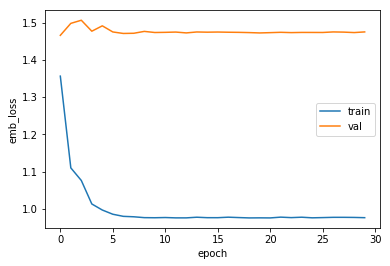

In [46]:
plt.plot(model.history.history['embedding_loss'], label='train');
plt.plot(model.history.history['val_embedding_loss'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('emb_loss');